I have used the following methods.


* I used a pretrained <b>Faster R-CNN with ResNet-50 Feature Pyramid Network</b> from detectron2 [1,2],
* I have modified the official notebook [3],
* I downloaded COCO json files [4],

## My Another Projects
* [Mammals Classification w/Ensemble Deep Learning](https://www.kaggle.com/code/banddaniel/mammals-classification-w-ensemble-deep-learning)
* [Rice Classification w/Custom ResNet50 (ACC 85%)](https://www.kaggle.com/code/banddaniel/rice-classification-w-custom-resnet50-acc-85)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Plate Detection w/detectron2 (mAP@75: 89.19)](https://www.kaggle.com/code/banddaniel/plate-detection-w-detectron2-map-75-89-19)


## References
1. Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1506.01497
2. https://detectron2.readthedocs.io/en/latest/
3. https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5
4. https://universe.roboflow.com/selfdriving-car-qtywx/self-driving-cars-lfjou/dataset/6

In [1]:
import sys, os, distutils.core
from IPython.display import clear_output

!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
clear_output()

In [2]:
# Importing dependencies

import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 10
THRESHOLD = 0.7

detectron2 version: 0.6


# <span style="color:#e74c3c;"> Creating </span> COCO Datasets

In [3]:
# Creating coco instances

from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

for d in ["train", "valid", "test"]:
    register_coco_instances(f"traffic_signs_{d}", {},
                            f"../input/traffic-signs-detection-coco-annotations/{d}_annotations.coco.json",
                            f"../input/cardetection/car/{d}/images")

# <span style="color:#e74c3c;"> Train </span> Samples

In [4]:
# Examples from the training dataset

import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("traffic_signs_train")
train_dataset_dicts = DatasetCatalog.get("traffic_signs_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]
    
    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

WARNING [11/28 12:45:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/28 12:45:36 d2.data.datasets.coco]: Loaded 3530 images in COCO format from ../input/traffic-signs-detection-coco-annotations/train_annotations.coco.json


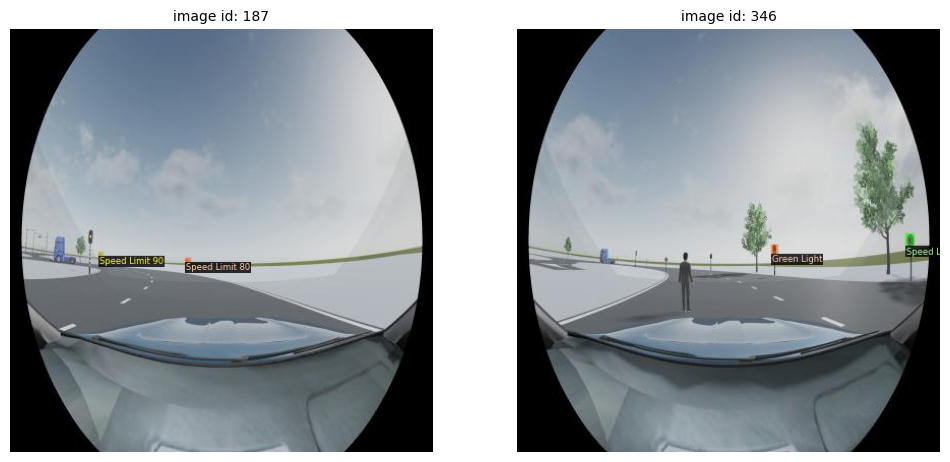

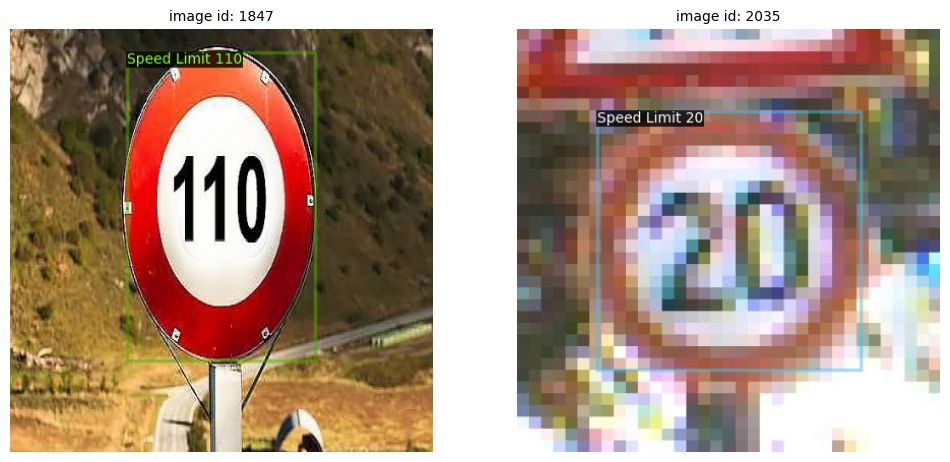

In [5]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 35 , image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 99 , image_scale = 1)

# <span style="color:#e74c3c;">Model</span>

In [6]:
from detectron2.engine import DefaultTrainer

EPOCHS = 9000
NUM_CLASSES = 15
BASE_LR = 0.001


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("traffic_signs_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/28 12:45:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_b275ba.pkl: 167MB [00:00, 170MB/s]                           


[11/28 12:45:43 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/28 12:45:56 d2.utils.events]:  eta: 0:30:07  iter: 19  total_loss: 2.715  loss_cls: 2.564  loss_box_reg: 0.1143  loss_rpn_cls: 0.007852  loss_rpn_loc: 0.009172    time: 0.2057  last_time: 0.2001  data_time: 0.0102  last_data_time: 0.0046   lr: 1.9981e-05  max_mem: 1736M


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[11/28 12:46:13 d2.utils.events]:  eta: 0:30:18  iter: 39  total_loss: 2.148  loss_cls: 1.966  loss_box_reg: 0.106  loss_rpn_cls: 0.01506  loss_rpn_loc: 0.006897    time: 0.2501  last_time: 0.2195  data_time: 0.0052  last_data_time: 0.0061   lr: 3.9961e-05  max_mem: 1737M
[11/28 12:46:17 d2.utils.events]:  eta: 0:30:43  iter: 59  total_loss: 1.09  loss_cls: 0.8331  loss_box_reg: 0.1092  loss_rpn_cls: 0.0282  loss_rpn_loc: 0.01279    time: 0.2336  last_time: 0.1989  data_time: 0.0055  last_data_time: 0.0052   lr: 5.9941e-05  max_mem: 1738M
[11/28 12:46:21 d2.utils.events]:  eta: 0:30:24  iter: 79  total_loss: 0.4329  loss_cls: 0.2493  loss_box_reg: 0.1199  loss_rpn_cls: 0.006588  loss_rpn_loc: 0.008666    time: 0.2253  last_time: 0.2107  data_time: 0.0049  last_data_time: 0.0048   lr: 7.9921e-05  max_mem: 1738M
[11/28 12:46:24 d2.utils.events]:  eta: 0:29:50  iter: 99  total_loss: 0.3876  loss_cls: 0.2171  loss_box_reg: 0.1214  loss_rpn_cls: 0.008276  loss_rpn_loc: 0.006821    time: 0.2

In [7]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[11/28 13:15:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


# <span style="color:#e74c3c;"> Training </span> Results

In [8]:
# original code from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

def reading_metrics_from_json(metrics_path):
    metrics = []
    
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [9]:
train_metrics = reading_metrics_from_json('/kaggle/working/output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

Text(0.5, 1.0, 'False Negative')

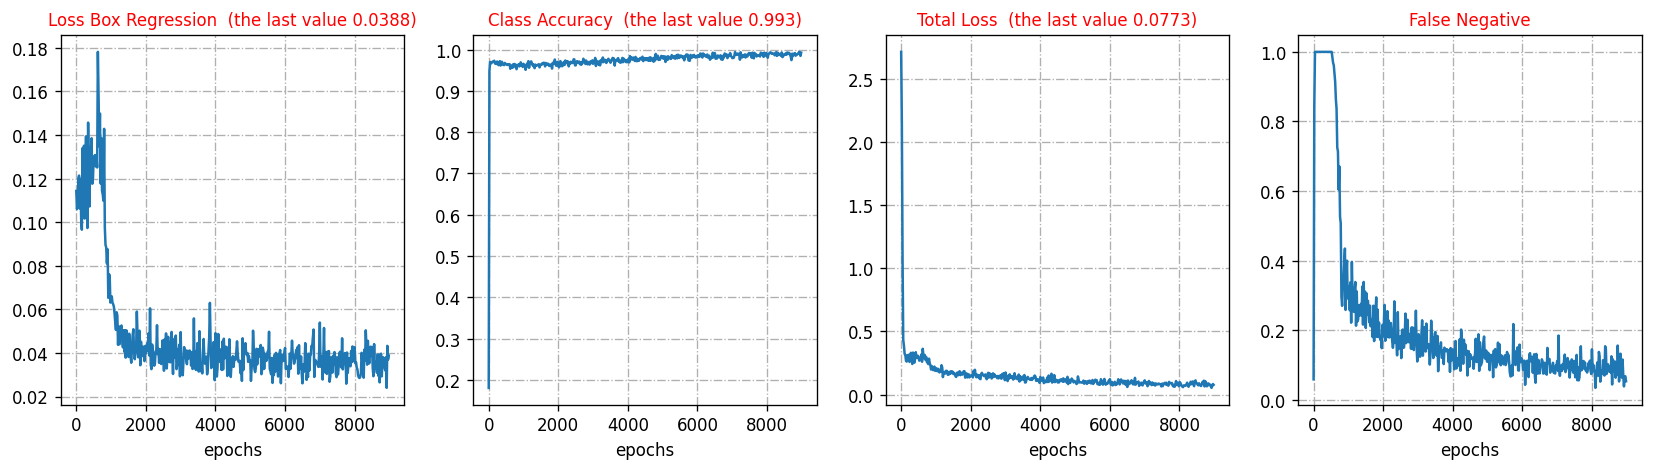

In [10]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

# <span style="color:#e74c3c;"> Validation </span> Results

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("traffic_signs_valid", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "traffic_signs_valid")
inference_on_dataset(trainer.model, test_loader, evaluator)

[11/28 13:15:45 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [11/28 13:15:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/28 13:15:45 d2.data.datasets.coco]: Loaded 801 images in COCO format from ../input/traffic-signs-detection-coco-annotations/valid_annotations.coco.json
[11/28 13:15:45 d2.data.build]: Distribution of instances among all 16 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|     Signs     | 0            |  Green Light  | 122          |   Red Light   | 108          |
| Speed Limit.. | 0            | Speed Limit.. | 52           | Speed Limit.. | 17           |
| Speed Limit.. | 60           | Speed Limit.. | 56           | Speed Limit.. | 74           |
| Speed Limit.. | 55           | Sp

OrderedDict([('bbox',
              {'AP': 60.94443287329262,
               'AP50': 78.57565075561608,
               'AP75': 69.36006406890164,
               'APs': 26.19174692947909,
               'APm': 65.10793552141972,
               'APl': 69.8502393748466,
               'AP-Signs': nan,
               'AP-Green Light': 43.49014006947757,
               'AP-Red Light': 39.07617058501029,
               'AP-Speed Limit 10': nan,
               'AP-Speed Limit 100': 76.72092536848965,
               'AP-Speed Limit 110': 65.77734642147739,
               'AP-Speed Limit 120': 75.57904394870197,
               'AP-Speed Limit 20': 77.28012998729356,
               'AP-Speed Limit 30': 79.62559969014126,
               'AP-Speed Limit 40': 76.44548643496171,
               'AP-Speed Limit 50': 74.20212259953054,
               'AP-Speed Limit 60': 74.32229630229492,
               'AP-Speed Limit 70': 82.32550718172095,
               'AP-Speed Limit 80': 51.465292584352284,
   

# <span style="color:#e74c3c;"> Test </span> Results

In [12]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("traffic_signs_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "traffic_signs_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[11/28 13:16:28 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [11/28 13:16:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/28 13:16:28 d2.data.datasets.coco]: Loaded 638 images in COCO format from ../input/traffic-signs-detection-coco-annotations/test_annotations.coco.json
[11/28 13:16:28 d2.data.build]: Distribution of instances among all 16 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|     Signs     | 0            |  Green Light  | 110          |   Red Light   | 94           |
| Speed Limit.. | 3            | Speed Limit.. | 46           | Speed Limit.. | 21           |
| Speed Limit.. | 44           | Speed Limit.. | 46           | Speed Limit.. | 60           |
| Speed Limit.. | 53           | Spe

OrderedDict([('bbox',
              {'AP': 55.77407125922406,
               'AP50': 71.62871904632013,
               'AP75': 64.20090065464275,
               'APs': 27.874947245116832,
               'APm': 52.965403112850794,
               'APl': 69.47941126595977,
               'AP-Signs': nan,
               'AP-Green Light': 47.78281954114786,
               'AP-Red Light': 41.638489751861634,
               'AP-Speed Limit 10': 17.95125666412795,
               'AP-Speed Limit 100': 71.25871300700666,
               'AP-Speed Limit 110': 57.53327281009179,
               'AP-Speed Limit 120': 72.30560731459332,
               'AP-Speed Limit 20': 80.81241042574425,
               'AP-Speed Limit 30': 73.31296489156237,
               'AP-Speed Limit 40': 74.09803785173376,
               'AP-Speed Limit 50': 71.65779138271637,
               'AP-Speed Limit 60': 66.58667396452604,
               'AP-Speed Limit 70': 71.90452078433566,
               'AP-Speed Limit 80': 58.85

# <span style="color:#e74c3c;"> Test </span> Predictions

In [13]:
my_dataset_test_metadata = MetadataCatalog.get("traffic_signs_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("traffic_signs_test")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]
    
    fig, axs = plt.subplots(3,2, figsize = (10,20), dpi = 200)
    
    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()
        
        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        
        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)
        
        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

WARNING [11/28 13:17:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/28 13:17:02 d2.data.datasets.coco]: Loaded 638 images in COCO format from ../input/traffic-signs-detection-coco-annotations/test_annotations.coco.json


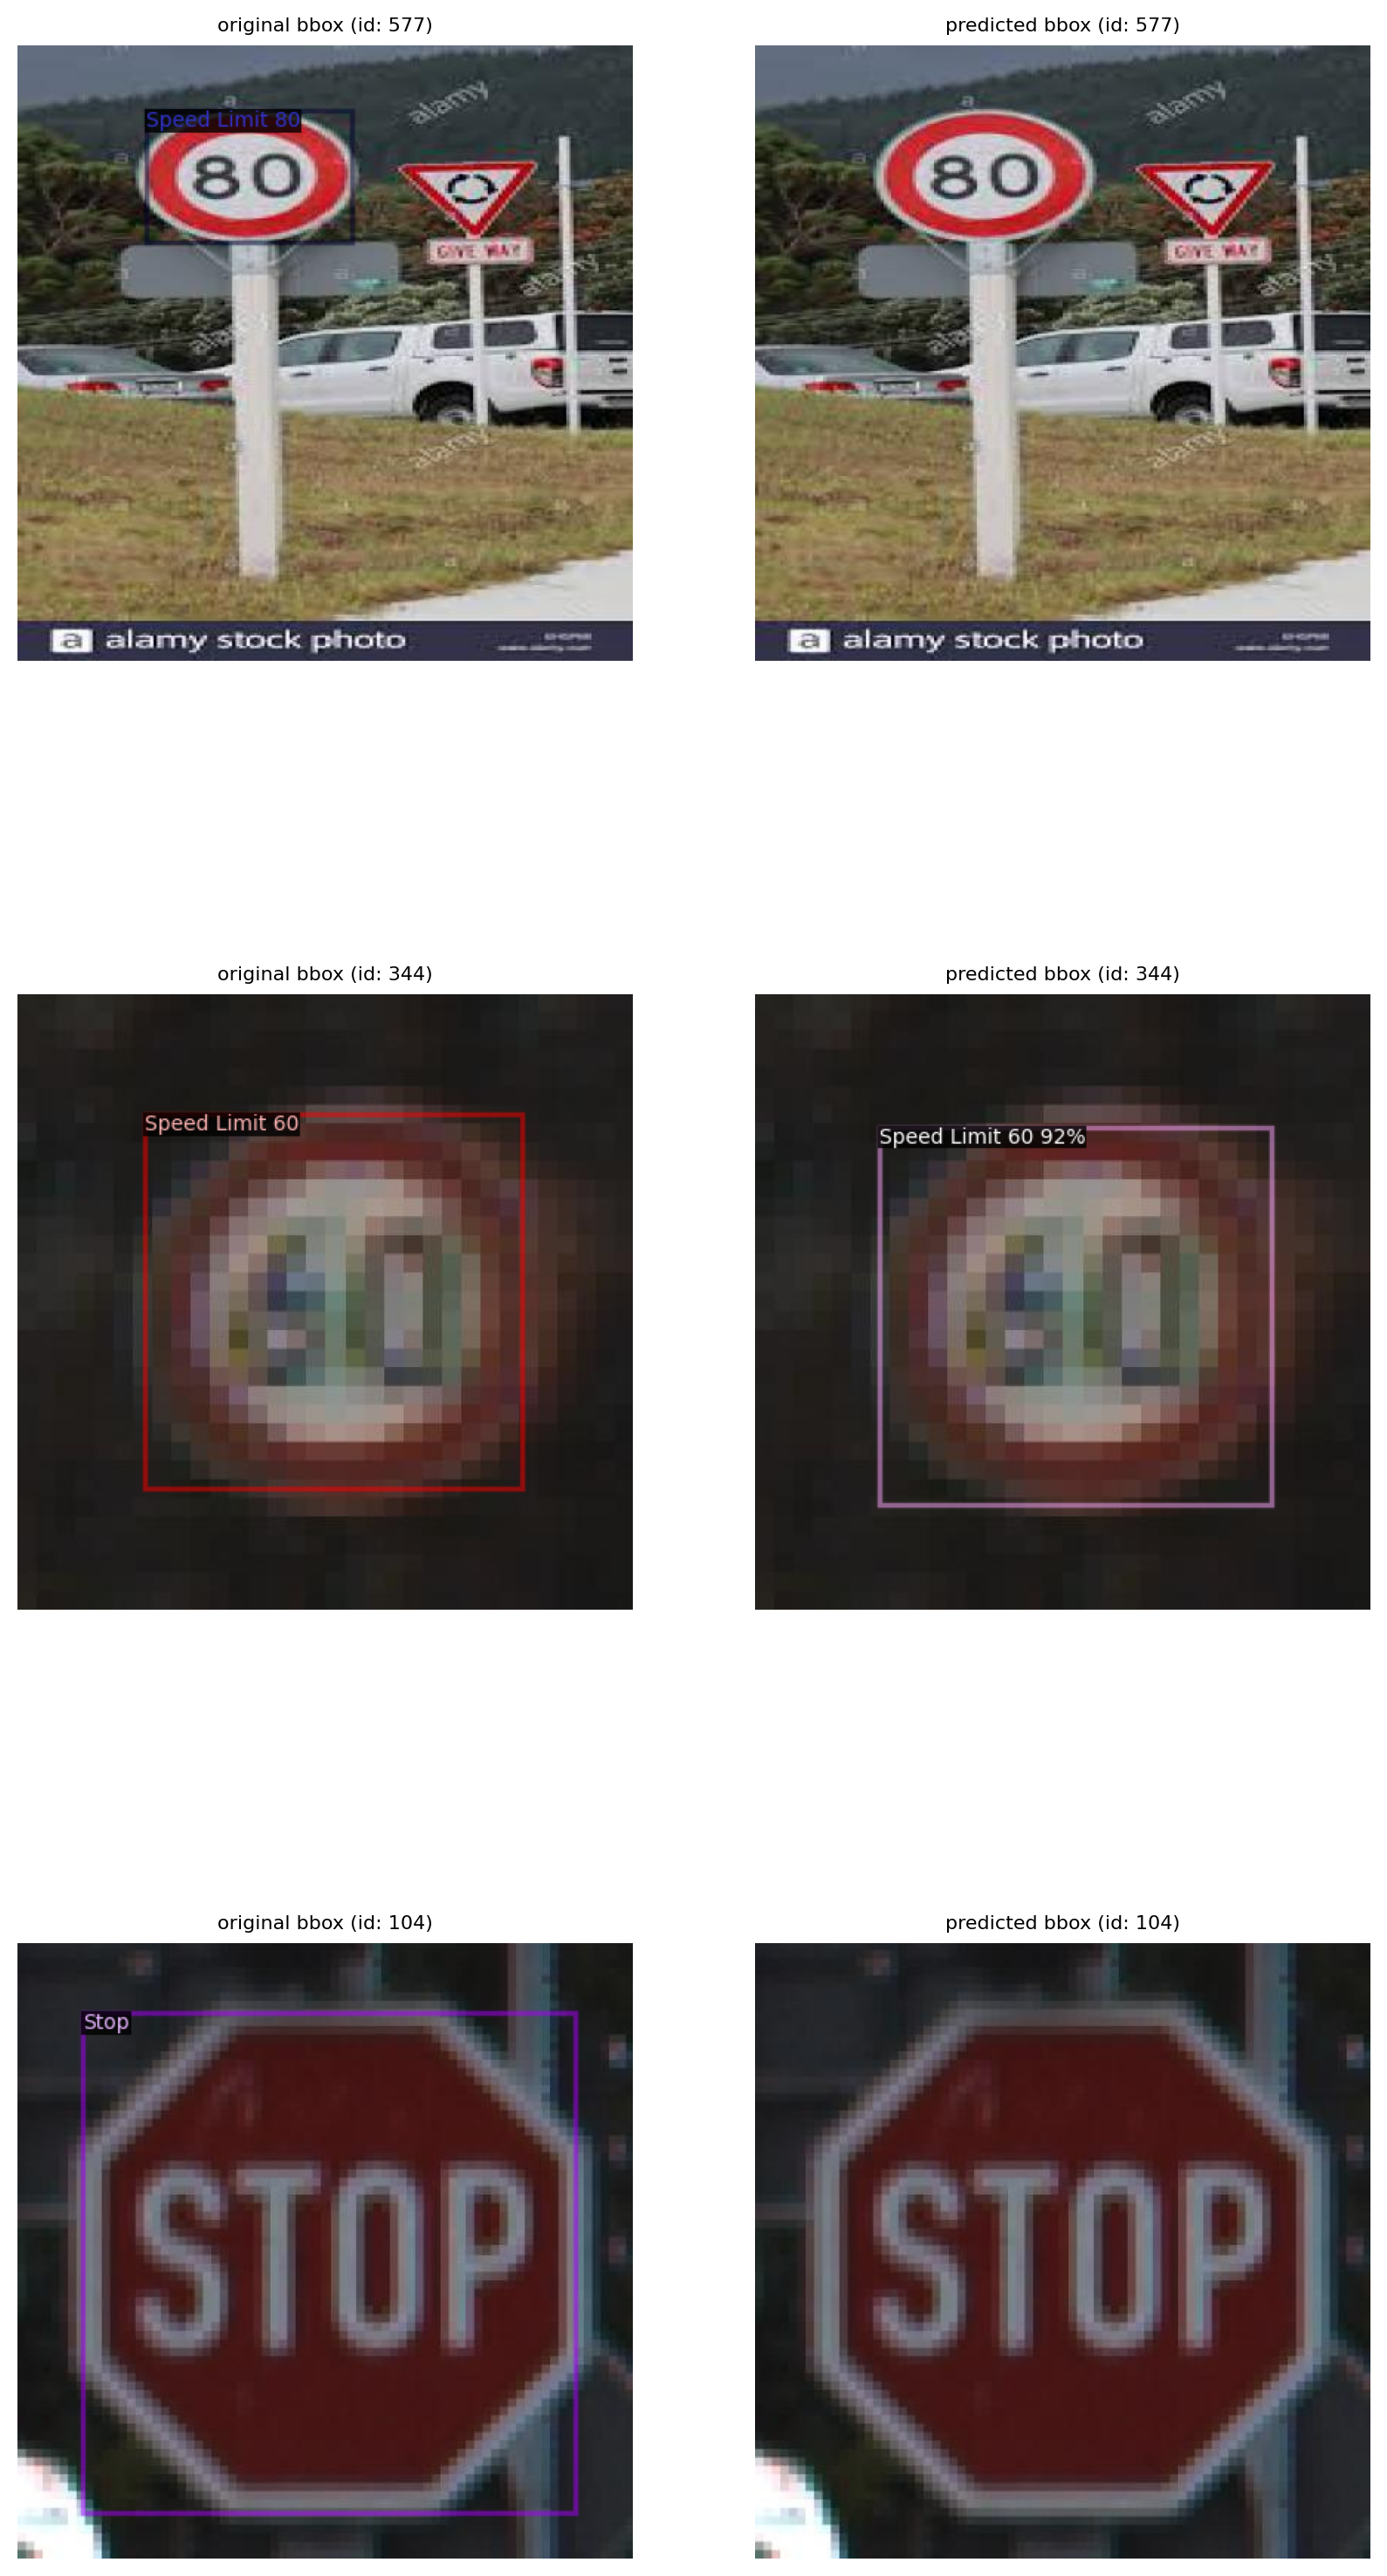

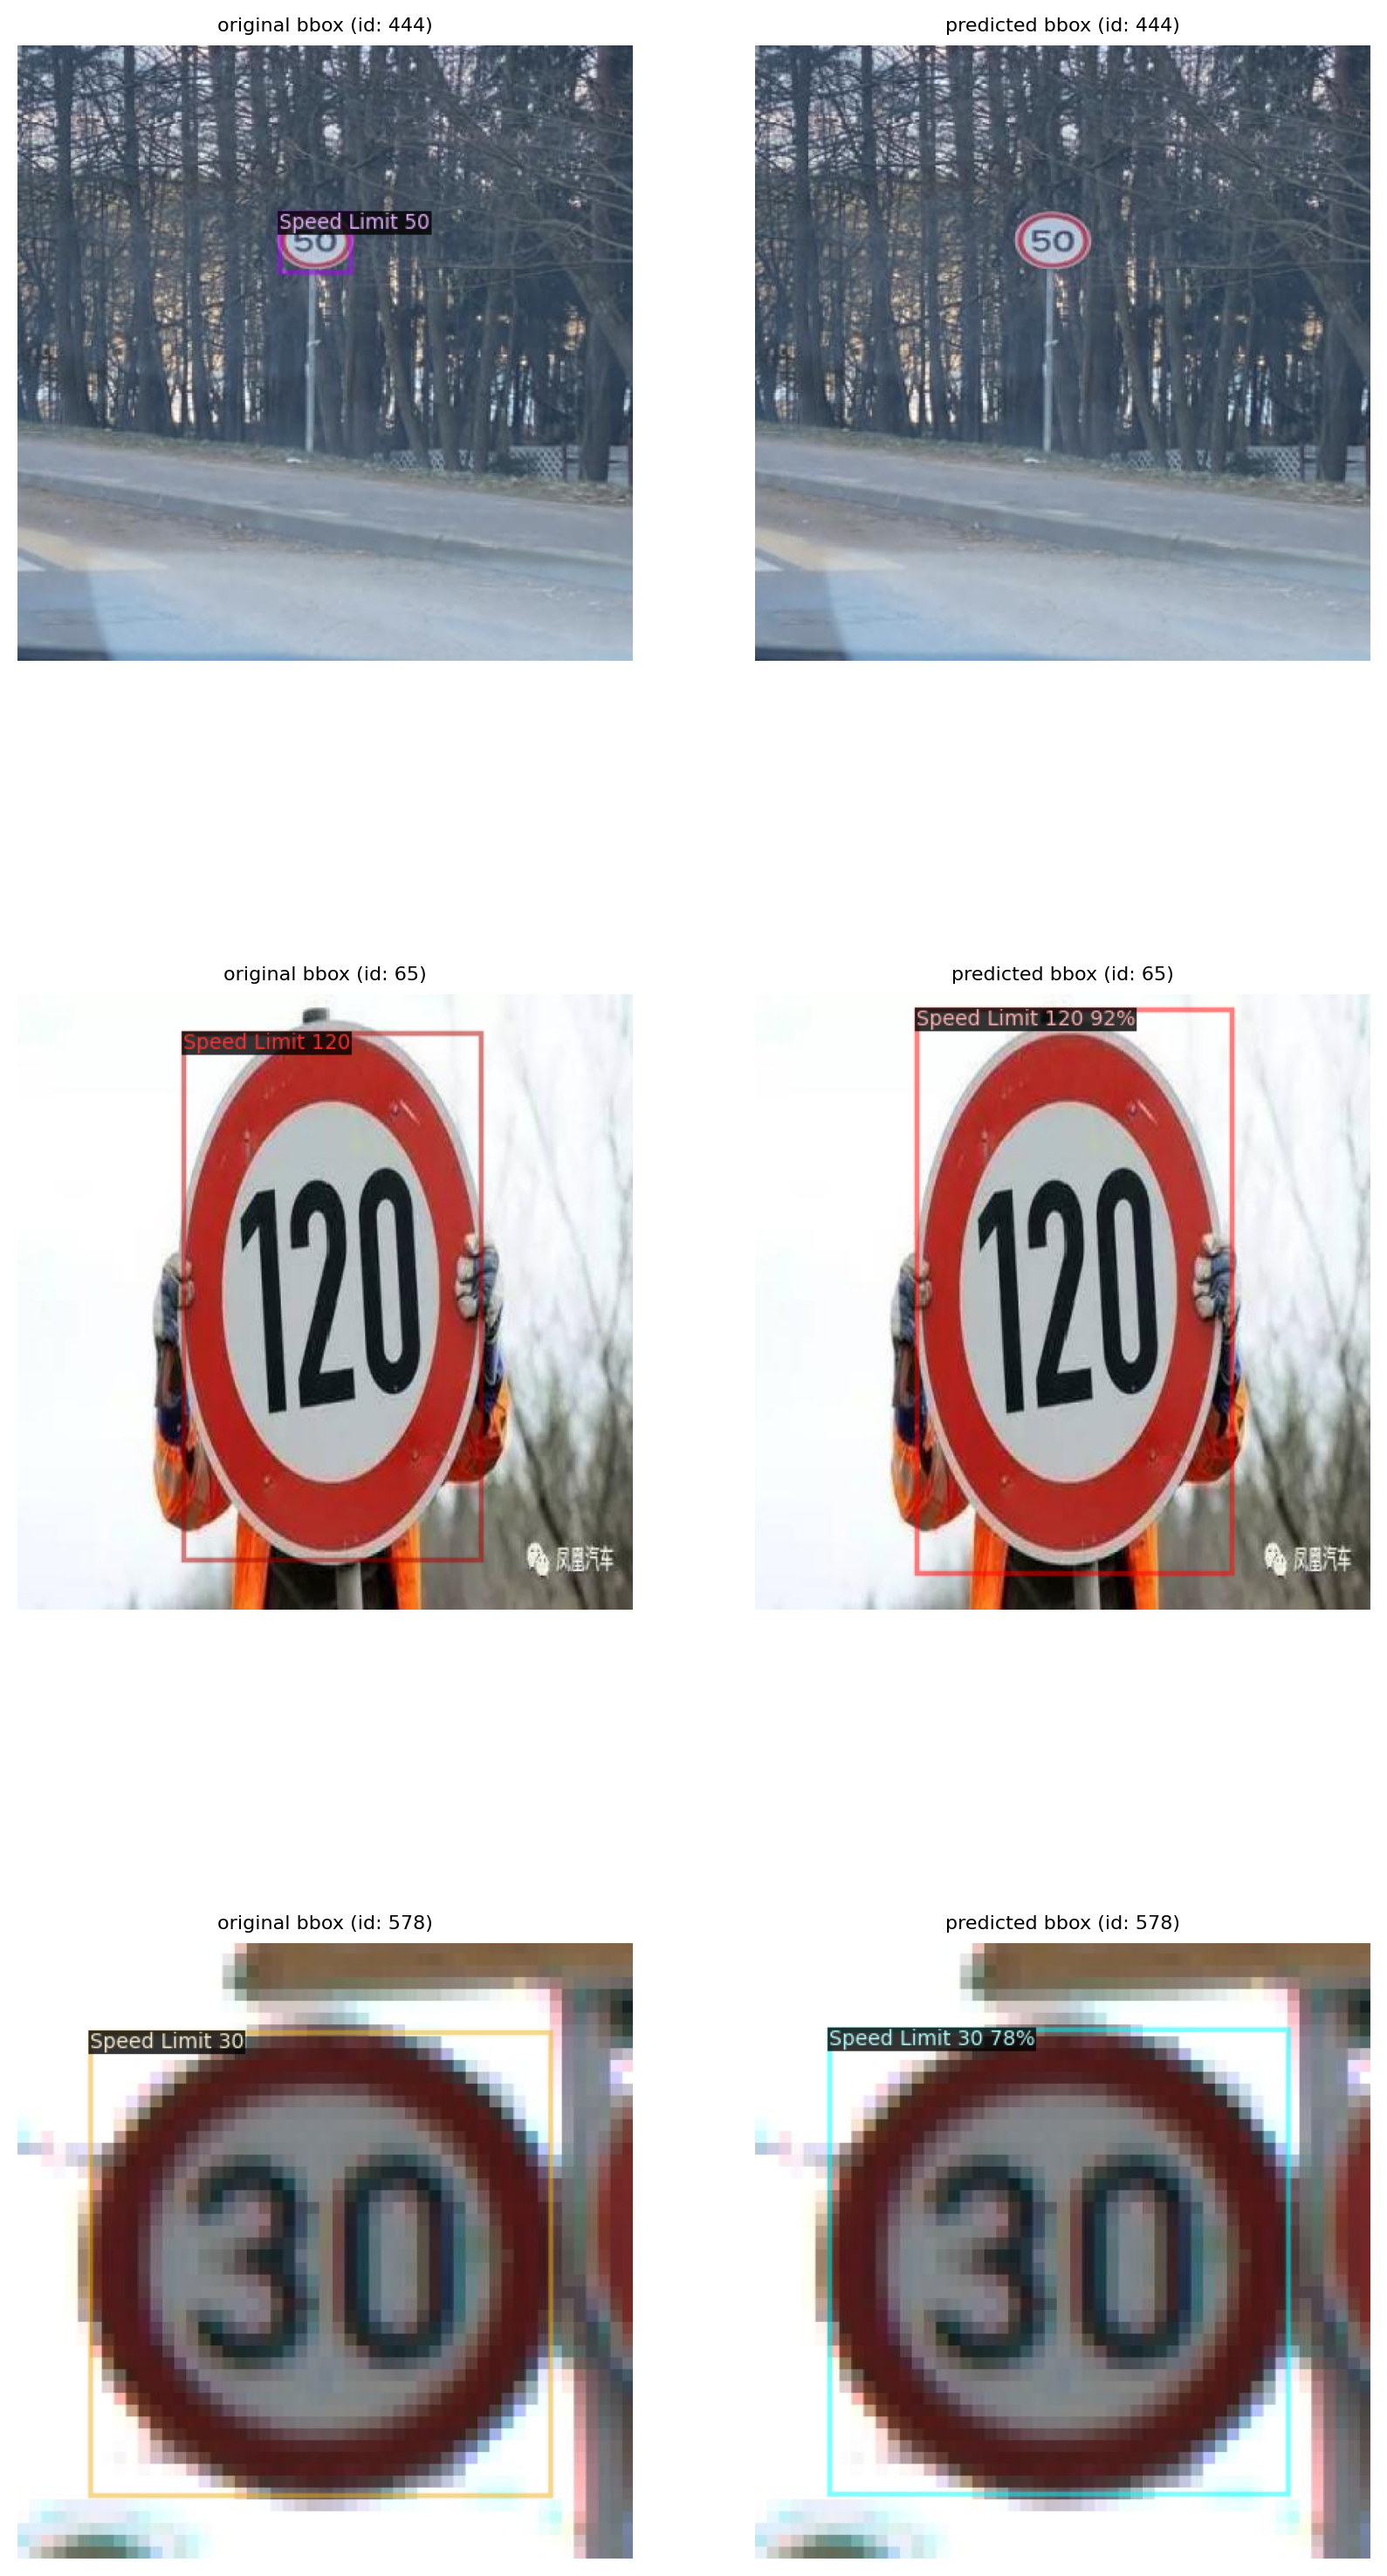

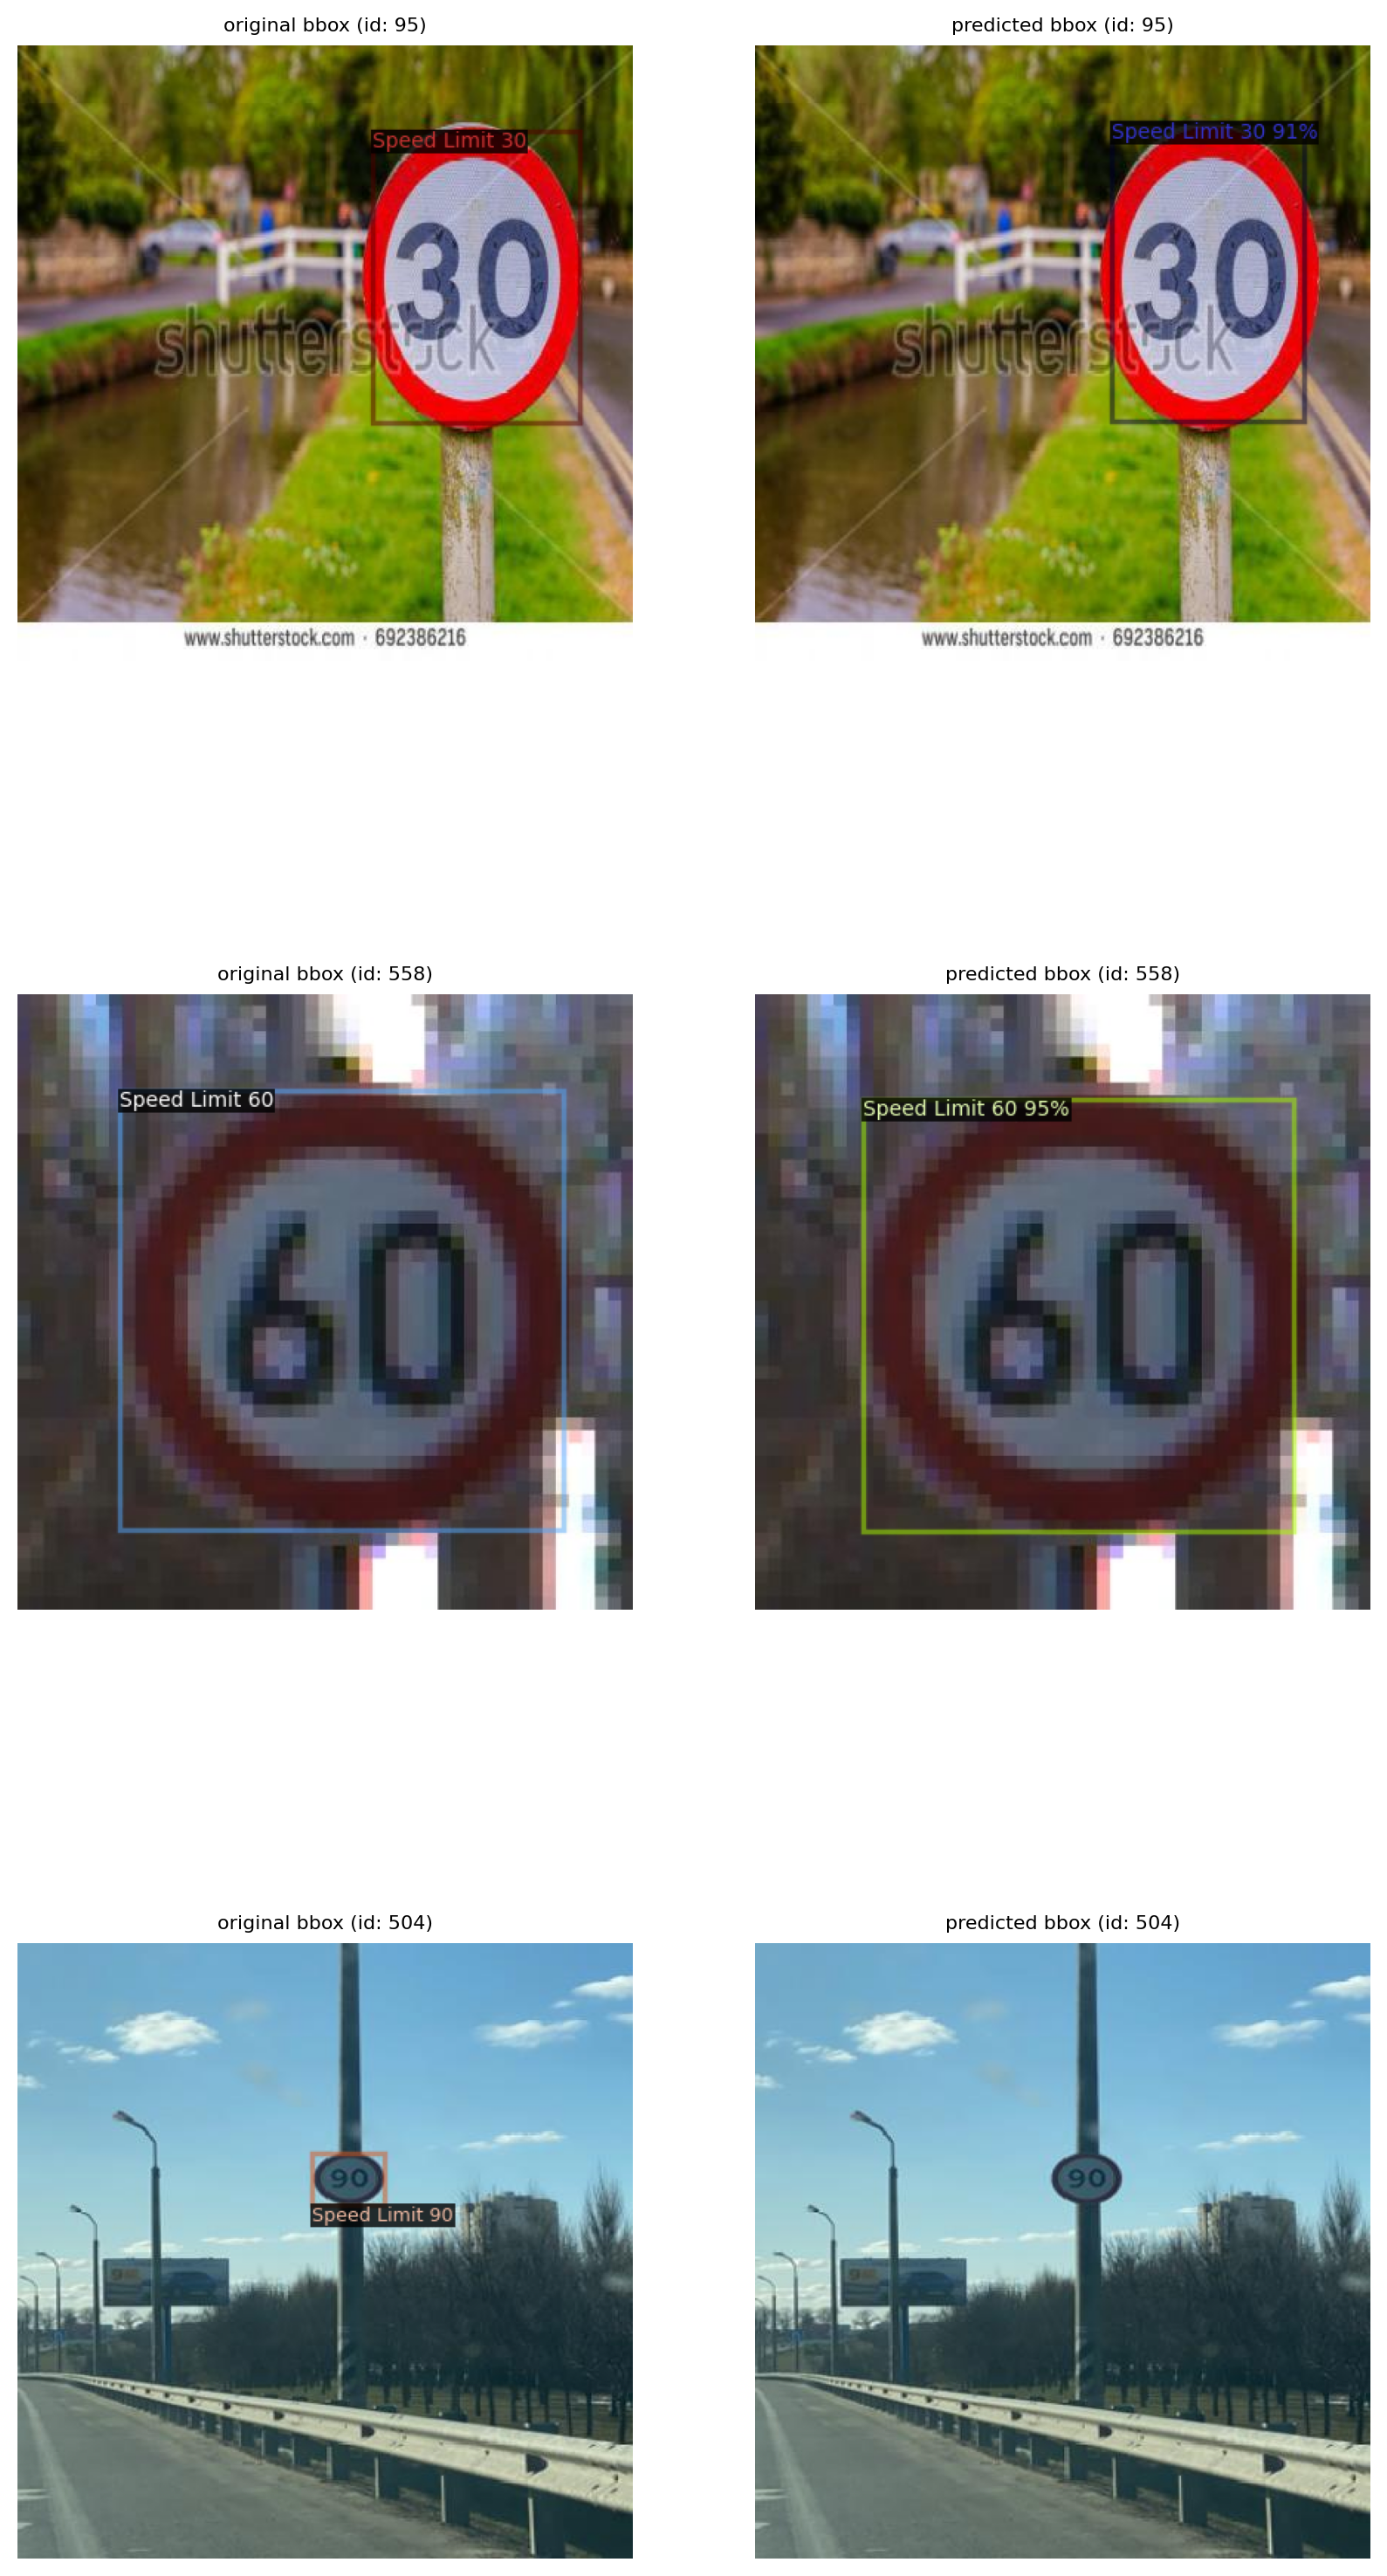

In [14]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 5, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 4, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 75, image_scale=1)